In [9]:
## PACKAGES
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output

In [10]:
##LOAD DATA
expr_file = r"./data/Survival_TCGA_VS_Desmd/modified_TCGA_BRCA_log2.csv"
expr = pd.read_csv(expr_file, encoding='utf-8', engine='python')
expr=expr.transpose()
expr.columns=expr.iloc[0]
X = expr.iloc[1:,1:-1].values
X=X.astype(float)
Y = expr.iloc[1:,-1].values
genes = expr.iloc[:,:-1].columns.to_numpy()


In [11]:
random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.2, shuffle=True, stratify=Y)

Remove low variance data. In this case the bottom 30%.

In [12]:
var_filter = X.var(0) >= np.percentile(X.var(0), 30., method='nearest')

In [15]:
X_train

array([[-33.21928095, -33.21928095,   6.6726884 , ...,   9.38672948,
          5.92516156, -33.21928095],
       [-33.21928095,  -1.80440042,   6.35832944, ...,  10.38144118,
          9.65609249,  -0.80440042],
       [-33.21928095, -33.21928095,   5.84361961, ...,  10.48916598,
          3.83740844, -33.21928095],
       ...,
       [-33.21928095, -33.21928095,   6.05353061, ...,   9.0643014 ,
          8.69250461, -33.21928095],
       [-33.21928095,   1.4783506 ,   6.14427483, ...,  10.15272684,
          8.56462205, -33.21928095],
       [-33.21928095, -33.21928095,   6.82296718, ...,   9.96491278,
          2.97272941, -33.21928095]])

In [16]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])


Encode the classes

In [17]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

#### Why we use fit_transform() on training data but transform() on the test data?

The fit_transform method calculates the mean and the variance of each features in the data and transforms all the features using the respective mean and variance. If we will use the fit method on our test data too, we will compute a new mean and variance that is a new scale for each feature and will let our model learn about our test data too. Thus, what we want to keep as a surprise is no longer unknown to our model and we will not get a good estimate of how our model is performing on the test (unseen) data which is the ultimate goal of building a model using machine learning algorithm.

This is the standard procedure to scale our data while building a machine learning model so that our model is not biased towards a particular feature of the dataset and at the same time prevents our model to learn the features/values/trends of our test data.

In [18]:
num_classes

2

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [86]:
reducer = umap.UMAP(
    n_neighbors=40,
    n_components=2,
    min_dist=0.99,
    metric='cosine',
    n_jobs=-1,
    random_state=42
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

(14351, 2)


/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/pyDeepInsight/image_transformer.py:271: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


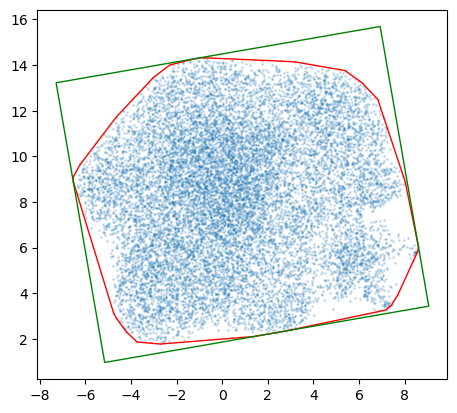

In [87]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

## CNN Image Classification
Train ResNet50 CNN

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
net = timm.create_model('resnet50', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

In [90]:
batch_size=10
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [91]:
criterion = nn.CrossEntropyLoss()
##optimizer = optim.SGD(net.parameters(),lr=1e-02,momentum=2,)
optimizer = optim.Adam(net.parameters(),lr=0.0001)

In [92]:
net.train()
for epoch in range(100):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

'Epoch 099, batch 012'

In [93]:
test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()

with torch.no_grad():
    y_hat = net(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The train accuracy was {accuracy_score(train_predicted.cpu(), y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")



The train accuracy was 1.000
The test accuracy was 0.613


In [51]:
train_predicted

tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0], device='cuda:0')

## SqueezeNet

In [79]:
import torchvision
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [80]:
model_sq = torchvision.models.squeezenet1_1(weights='DEFAULT')
model_sq.classifier.append(nn.Flatten())
_ = model_sq.classifier.append(nn.Linear(1000, num_classes))

##transforming image to tensor
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [81]:
X_train_tensor_sq = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor_sq = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor_sq = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor_sq = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [82]:
batch_size = 10

trainset = TensorDataset(X_train_tensor_sq, y_train_tensor_sq)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor_sq, y_test_tensor_sq)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model_sq.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

## DeepFeature: CAM-based Feature Selection

In [84]:
model_sq.train()
model_sq.to(device1)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device1)
        labels = labels.to(device1)

        outputs = model_sq(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')

[0] loss: 1.245
[20] loss: 0.655
[40] loss: 0.708
[60] loss: 0.609
[80] loss: 0.138
[100] loss: 0.000
[119] loss: 0.000


In [58]:
model_sq.to('cpu')
model_sq = model_sq.eval()

with torch.no_grad():
    y_hat = model_sq(X_train_tensor_sq)
train_predicted = torch.max(y_hat, 1)[1]


with torch.no_grad():
    y_hat = model_sq(X_test_tensor_sq)
test_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor_sq):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor_sq):.3f}")

The train accuracy was 1.000
The test accuracy was 0.613


In [59]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [60]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

OutOfMemoryError: CUDA out of memory. Tried to allocate 308.00 MiB (GPU 0; 23.64 GiB total capacity; 2.95 GiB already allocated; 256.38 MiB free; 3.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

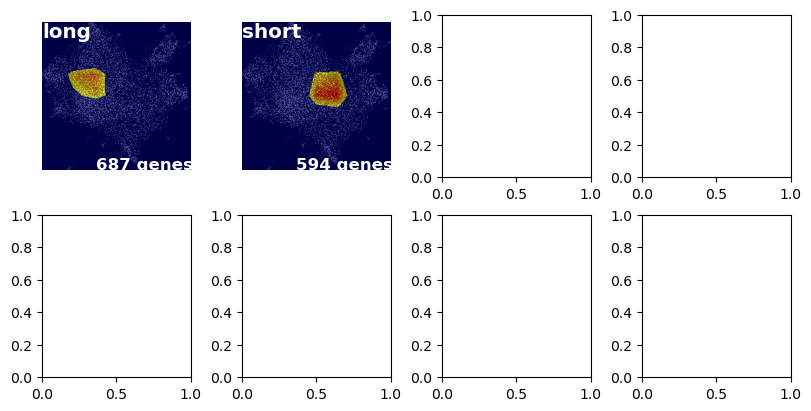

In [ ]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

In [ ]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")

  687 features selected for long: RFC2, PAX8, PTPN21, ESRRA, GAS6, MMP14, SRP14, RPL24, SEPTIN2...
  594 features selected for short: CYP2A6, BAD, PRPF8, CAPNS1, RPL35, EIF3D, SRP14, HNRNPA1, EIF3F...
